In [2]:
# IN-DEPTH: SUPPORT VECTOR MACHINES
# Support vector machines (SVMs) are a particularly powerful and flexible
# class of supervised algorithms for both classification and regression. 
# Let's begin with the standard imports.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy import stats
plt.style.use('dark_background')
# SVMs are used for *discriminative classification*: rather than modeling 
# each class, we simply find a line or curve (in two dimensions) or
# manifold (in multiple dimensions) that divides the classes from each other.

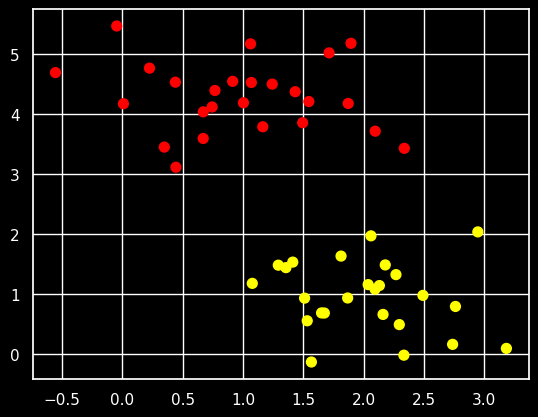

In [6]:
# As an example, consider the simple case of a classification task, in
# which the two classes of points are well separated:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples = 50, centers = 2,
                  random_state = 0, cluster_std = .6)
plt.scatter(X[:, 0], X[:, 1], c = y, s = 50, cmap = 'autumn');
# A linear discriminative classifier would attempt to draw a straight line
# separating the two sets of data, and thereby create a model for
# classification. For two-dimensional data like that shown here, this is a
# task we could do by hand. But immediately we see a problem, there is more
# than one possible dividing line that can perfectly discriminate between 
# the two classes!

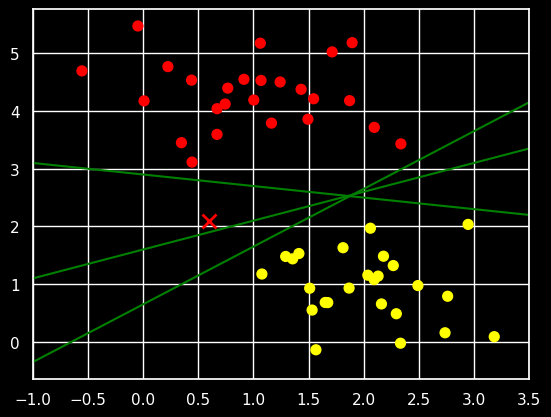

In [14]:
# We can draw them as follows
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c = y, s = 50, cmap = 'autumn')
plt.plot([.6], [2.1], 'x', color = 'red',
         markeredgewidth = 2, markersize = 10)
for m, b in [(1, .65), (.5, 1.6), (-.2, 2.9)]:
    plt.plot(xfit, m*xfit + b, color = 'green')
plt.xlim(-1, 3.5);
# These are three very different separators that, nevertheless, perfectly 
# discriminate between these samples. Depending on which you choose, a new
# data point (e.g., the one marked by the "X") will be assigned a different 
# label! It's evident that our simple intuiton of "drawing a line between 
# classes" is not enough!

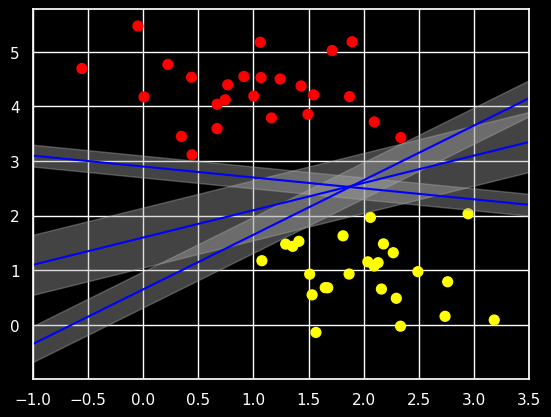

In [25]:
# SUPPORT VECTOR MACHINES: MAXIMIZING THE MARGIN
# SVMs offer one way to improve on this. The intuition is the following:
# rather than simply drawing a zero-width line between the classes, we can
# draw around each line a *margin* of some width, up to the nearest point.
# Here's an example of how this might look:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c = y, s = 50, cmap = 'autumn')
for m, b, d in [(1, .65, .33), (.5, 1.6, .55), (-.2, 2.9, .2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, color = 'blue')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor = 'none',
                     color = '#AAAAAA', alpha = .4)
plt.xlim(-1, 3.5);
# In SVMs, the line that maximises this margin is the one we will choose as
# the optimal model. Support vector machines are an example of such a
# *maximum margin* estimator.

In [26]:
# FITTING A SUPPORT VECTOR MACHINE
# Let's see the result of an actual fit to this data: we will use
# scikit-learn's support vector classifier to train an SVM model on this 
# data. For the time being, we will use a linear kernel and set the C
# parameter to a very large number.
from sklearn.svm import SVC  # "Support Vector Classifier"
model = SVC(kernel = 'linear', C = 1e10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

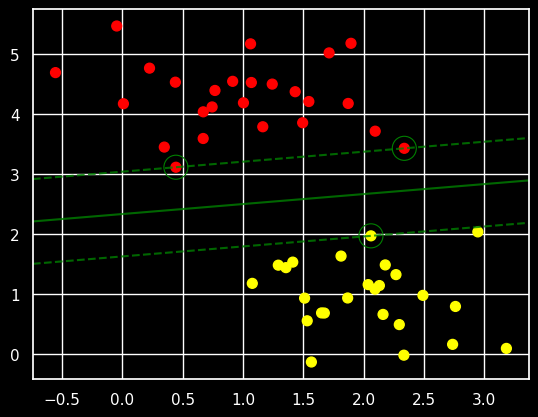

In [38]:
# To better visualize what is going on, let's create a quick convenience 
# function that will plot SVM decision boundaries for us:
def plot_svc_decision_function(model, ax = None, 
                               plot_support = True) -> None:
    """Plot the decision function for a two-dimensional SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create a grid to evaluate the model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors = 'green',
               levels = [-1, 0, 1], alpha = .8,
               linestyles = ['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s = 300, linewidth = .8, color = 'green',
                   facecolors = 'none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return

plt.scatter(X[:, 0], X[:, 1], c = y, s = 50, cmap = 'autumn')
plot_svc_decision_function(model);

In [39]:
# This is the dividing line that maximizes the margin between the two sets
# of points. Notice that a few of the training points just touch the margin;
# they are indicated by the black circles. These points are the pivotal 
# elements of this fit, and are know as the *support vectors*, thus giving
# the algorithm its name. In sciki-learn, the identity of these points is 
# stored in the support_vectors_ attribute of the classifier.
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

In [40]:
# A key to this classifier's success is that for the fit, only the position
# of the support vectors matters; any points further from the margin that
# are on the correct side do not modify the fit! Technically, this is
# because these points do not contribute to the loss function used to fit
# the model, so their position and number do not matter so long as the do
# not cross the margin. We can see this, for example, if we plot the model
# learned from the first 60 points and first 120 points of this dataset.
def plot_svm(N = 10, ax = None) -> None:
    X, y = make_blobs(n_samples = 200, centers = 2,
                      random_state = 0, cluster_std = .6)
    X = X[:N]
